In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from pathlib import Path

sns.set_theme(style="whitegrid")

rng = np.random.default_rng()

In [2]:
images_path = Path() / "images"
images_path.mkdir(exist_ok=True)

In [3]:
N = 1000
S_0, E_0, I_0, H_0, R_0 = N - 51, 1, 50, 0, 0
y0 = np.array([S_0, E_0, I_0, H_0, R_0]) / N

beta = 0.5
b = 0
epsilon = 0.7
r1 = 0.4
r2 = 0.5
sigma = 0.9
gamma = 1/14
eta = 1/21
omega = 0.5
mu1 = 0.05
mu2 = 0.01
mu = 0
parameters = (
    beta,
    b,
    epsilon,
    r1,
    r2,
    sigma,
    gamma,
    eta,
    omega,
    mu1,
    mu2,
    mu
)

n_days = 60
t_data = np.arange(0, n_days, 1)
t_span = (t_data[0], t_data[-1])

In [4]:
def seihr(t, y, beta, b, epsilon, r1, r2, sigma, gamma, eta, omega, mu1, mu2, mu):
  S, E, I, H, R = y
  dS_dt = -beta * S * I * (1 - b)  - epsilon * beta * S * E * (1 - b) - mu * E
  dE_dt = beta * S * I * (1 - b) + epsilon * beta * S * E * (1 - b) - sigma * E + r1 * R - mu * E
  dI_dt = sigma * E - gamma * I - eta * I - mu1 * I + r2 * H - mu * I
  dH_dt = eta * I - omega * H - mu2 * H - r2 * H - mu * H
  dR_dt = gamma * I + omega * H - r1 * R - mu * R
  return np.array([dS_dt, dE_dt, dI_dt, dH_dt, dR_dt])

def seihr_exposed_forward(t_data, beta):
  sol = solve_ivp(seihr, t_span, y0, t_eval=t_data, args = (beta, b, epsilon, r1, r2, sigma, gamma, eta, omega, mu1, mu2, mu))
  return sol.y[1, :]  # Only Exposed

In [5]:
exposed = seihr_exposed_forward(t_data, parameters[0])
noise_perc = 0.05
e_noise = np.random.normal(loc=0, scale=exposed.std(axis=0), size=exposed.shape) * noise_perc
exposed_data = exposed + e_noise

/tmp/ipykernel_24350/3244929417.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


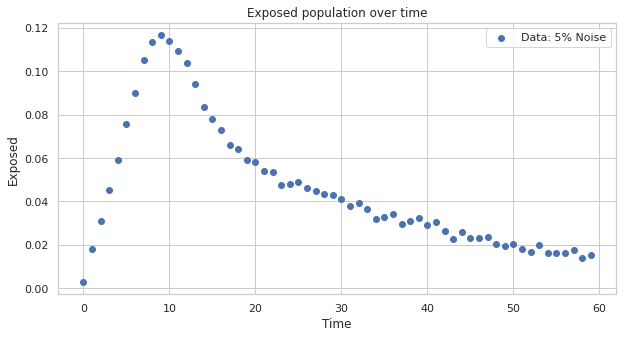

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(t_data, exposed_data, label=f"Data: {noise_perc:.0%} Noise")
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Exposed")
ax.set_title("Exposed population over time")
fig.show()

In [7]:
popt, pcov = curve_fit(seihr_exposed_forward, t_data, exposed_data)
popt  # beta

array([0.49779751])

In [8]:
rel_error = np.abs((beta - popt[0]) / beta)
print(rf"Relative error $\beta$: {rel_error:.4f}")

Relative error $\beta$: 0.0044


/tmp/ipykernel_24350/1604177112.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


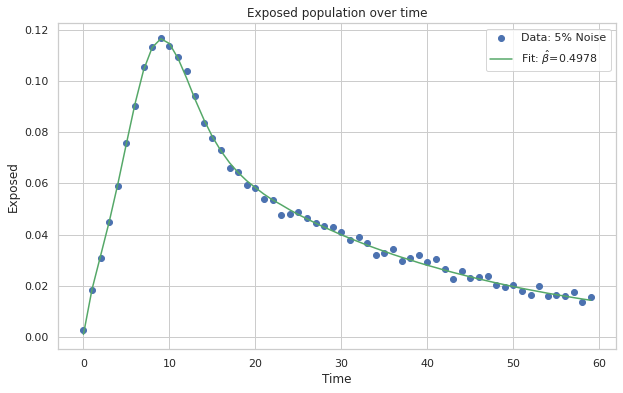

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(t_data, exposed_data, label=f"Data: {noise_perc:.0%} Noise")
ax.plot(
    t_data,
    seihr_exposed_forward(t_data, *popt),
    c="g",
    label=r"Fit: $\hat{\beta}$=" + f"{popt[0]:.4f}"
)
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Exposed")
ax.set_title("Exposed population over time")
fig.savefig(images_path / f"SEIHR_least_squares.png", dpi=300)
fig.show()